<a href="https://colab.research.google.com/github/kartikayladdha/BDT/blob/main/BDT%20Project/%20BDT_Project_ICA_SEM6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas_datareader

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from __future__ import division
import datetime

In [2]:
from pandas_datareader import data as web

In [3]:
def get(tickers, startdate, enddate):
  def data(ticker):
    return (web.DataReader(ticker, data_source='yahoo', start=startdate, end=enddate))
  datas = map (data, tickers)
  return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['JINDALSTEL.NS', 'JSWSTEEL.NS', 'HINDALCO.NS','TATASTEEL.NS']
all_data = get(tickers, datetime.datetime(2015, 1, 1), datetime.datetime(2020, 1, 1))

In [4]:
all_data

High         Low  ...      Volume   Adj Close
Ticker        Date                                ...                        
JINDALSTEL.NS 2015-01-01  158.350006  150.500000  ...   6913722.0  156.550003
              2015-01-02  164.600006  157.600006  ...   8169041.0  161.949997
              2015-01-05  166.750000  161.199997  ...  12103749.0  162.850006
              2015-01-06  163.399994  151.050003  ...   9730592.0  152.649994
              2015-01-07  154.750000  148.600006  ...   5299465.0  150.350006
...                              ...         ...  ...         ...         ...
TATASTEEL.NS  2019-12-27  471.799988  463.200012  ...  11144333.0  457.637939
              2019-12-30  476.299988  465.100006  ...  11462074.0  462.755310
              2019-12-31  475.299988  469.500000  ...   9644145.0  460.123505
              2020-01-01  476.500000  464.799988  ...  12100530.0  455.932159
              2020-01-02  487.799988  472.000000  ...  21674961.0  472.600128

[4920 rows x 6 columns]

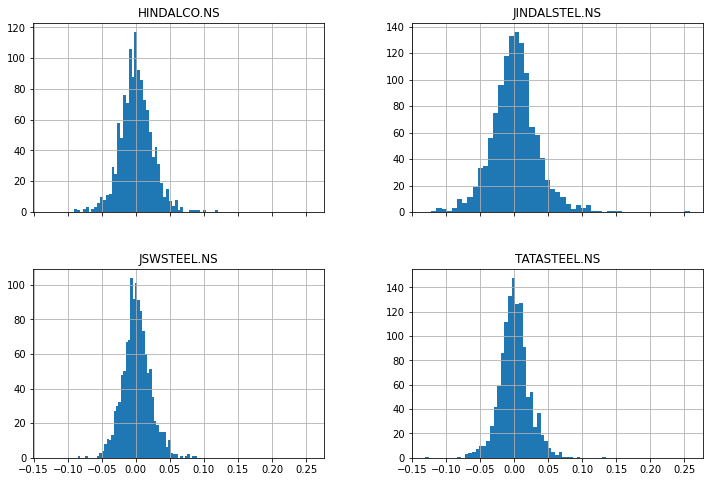

In [5]:
# Import matplotlib
import matplotlib.pyplot as plt 

# Isolate the `Adj Close` values and transform the DataFrame
daily_close_px = all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')

# Calculate the daily percentage change for `daily_close_px`
daily_pct_change = daily_close_px.pct_change()

# Plot the distributions
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))

# Show the resulting plot
plt.show()

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error,confusion_matrix, classification_report

In [7]:
datas=all_data

In [8]:
# Initialize the `signals` DataFrame with the `signal` column
datas['signal'] = 0.0

# Create short simple moving average over the short window
datas['short_mavg'] = datas['Close'].rolling(window=30, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
datas['long_mavg'] = datas['Close'].rolling(window=120, min_periods=1, center=False).mean()

# Create signals
datas['signal'] = np.where(datas['short_mavg'] > datas['long_mavg'], 1.0, 0.0)

In [9]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
datas['EMA21'] = EMA(datas, 21)
datas['EMA63'] = EMA(datas, 63)
datas['EMA252'] = EMA(datas, 252)
datas.head()

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC
datas['ROC21'] = ROC(datas['Close'], 21)
datas['ROC63'] = ROC(datas['Close'], 63)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM
datas['MOM21'] = MOM(datas['Close'], 21)
datas['MOM63'] = MOM(datas['Close'], 63)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 #rs = pd.stats.moments.ewma(u, com=period-1, adjust=False)
 rs=pd.DataFrame.ewm(u,com=period-1,adjust=False).mean() 
 pd.DataFrame.ewm(d,com=period-1,adjust=False).mean()
 #pd.stats.moments.ewma(d, com=period-1, adjust=False)
 return 100 - 100 / (1 + (rs))
datas['RSI21'] = RSI(datas['Close'], 21)
datas['RSI63'] = RSI(datas['Close'], 63)
datas['RSI252'] = RSI(datas['Close'], 252)

#calculation of stochastic osillator.

def STOK(close, low, high, n): 
 STOK = ((close - low.rolling(n).mean()) / (high.rolling(n).mean() - low.rolling(n).mean())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).mean()) / (high.rolling(n).mean() - low.rolling(n).mean())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD
datas['%K21'] = STOK(datas['Close'], datas['Low'], datas['High'], 21)
datas['%D21'] = STOD(datas['Close'], datas['Low'], datas['High'], 21)
datas['%K63'] = STOK(datas['Close'], datas['Low'], datas['High'], 63)
datas['%D63'] = STOD(datas['Close'], datas['Low'], datas['High'], 63)
datas['%K252'] = STOK(datas['Close'], datas['Low'], datas['High'], 252)
datas['%D252'] = STOD(datas['Close'], datas['Low'], datas['High'], 252)


In [10]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
datas['MA21'] = MA(datas, 21)
datas['MA63'] = MA(datas, 63)
datas['MA252'] = MA(datas, 252)
datas.tail()

High         Low  ...        MA63       MA252
Ticker       Date                                ...                        
TATASTEEL.NS 2019-12-27  471.799988  463.200012  ...  394.059524  452.268651
             2019-12-30  476.299988  465.100006  ...  395.709524  452.119842
             2019-12-31  475.299988  469.500000  ...  397.455556  451.955159
             2020-01-01  476.500000  464.799988  ...  398.915874  451.731945
             2020-01-02  487.799988  472.000000  ...  400.903175  451.564683

[5 rows x 28 columns]

In [36]:
#Dealing with rows that contain NAN

print(datas.isnull().sum())
datasub=datas.dropna()
datasub.isnull().sum()
datasub

High            0
Low             0
Open            0
Close           0
Volume          0
Adj Close       0
signal          0
short_mavg      0
long_mavg       0
EMA21          20
EMA63          62
EMA252        251
ROC21          20
ROC63          62
MOM21          21
MOM63          63
RSI21          21
RSI63          63
RSI252        252
%K21           20
%D21           22
%K63           62
%D63           64
%K252         251
%D252         253
MA21           20
MA63           62
MA252         251
dtype: int64


High         Low  ...        MA63       MA252
Ticker        Date                                ...                        
JINDALSTEL.NS 2016-01-12   85.449997   79.199997  ...   84.169048  110.177580
              2016-01-13   82.800003   74.599998  ...   84.302381  109.840080
              2016-01-14   76.750000   71.500000  ...   84.294444  109.520834
              2016-01-15   73.199997   62.000000  ...   84.126191  109.178175
              2016-01-18   64.900002   59.000000  ...   83.903175  108.789683
...                              ...         ...  ...         ...         ...
TATASTEEL.NS  2019-12-27  471.799988  463.200012  ...  394.059524  452.268651
              2019-12-30  476.299988  465.100006  ...  395.709524  452.119842
              2019-12-31  475.299988  469.500000  ...  397.455556  451.955159
              2020-01-01  476.500000  464.799988  ...  398.915874  451.731945
              2020-01-02  487.799988  472.000000  ...  400.903175  451.564683

[4667 rows x 28 columns]

In [37]:
datasub.to_excel('exp.xlsx')

In [12]:
#excluding columns that are not needed for our prediction.

datasubs=datasub.drop(['Close','High','Low','Open', 'Volume','short_mavg','long_mavg','Adj Close'], axis=1)
datasubs.head()

signal      EMA21  ...       MA63       MA252
Ticker        Date                           ...                       
JINDALSTEL.NS 2016-01-12     1.0  88.932469  ...  84.169048  110.177580
              2016-01-13     1.0  87.920426  ...  84.302381  109.840080
              2016-01-14     1.0  86.491296  ...  84.294444  109.520834
              2016-01-15     1.0  84.446633  ...  84.126191  109.178175
              2016-01-18     1.0  82.224212  ...  83.903175  108.789683

[5 rows x 20 columns]

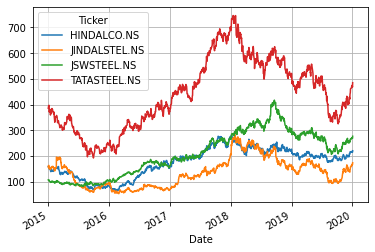

upward  56.50310692093422% out of 4667 total datasize


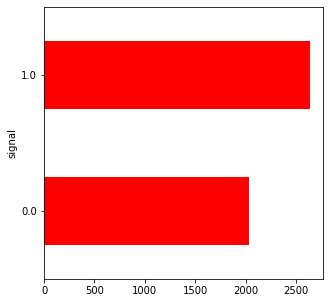

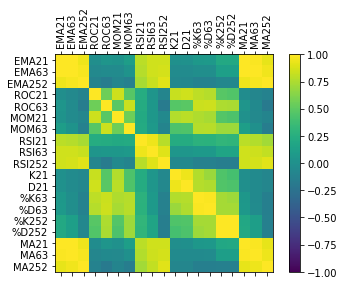

In [14]:
daily_close_px = datas[['Close']].reset_index().pivot('Date', 'Ticker', 'Close')
daily_close_px.plot(grid=True)
plt.show()

fig = plt.figure()
fig.set_size_inches(5,5)
data_s = datasubs.groupby(['signal']).size()
names=['EMA21','EMA63','EMA252','ROC21','ROC63','MOM21','MOM63','RSI21','RSI63','RSI252','K21','D21','%K63','%D63','%K252','%D252','MA21','MA63','MA252']

print("upward  {}% out of {} total datasize".format(100* data_s[1]/(data_s[1]+data_s[0]), data_s[1]+data_s[0]))
plot = data_s.plot(kind='barh', color='red')
X=datasubs.drop(['signal'], axis=1)
y=datasubs['signal']



correlations = X.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,19,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation = 90)
ax.set_yticklabels(names)
plt.show()

In [16]:
forest = RandomForestClassifier(n_estimators=500,random_state=1,n_jobs=-1)
forest.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

        Importance
RSI21     1.156203
%K21      1.491631
RSI63     1.532833
%D21      1.619572
MOM21     1.911548
ROC21     2.057489
EMA63     2.213268
EMA21     2.261497
MA21      2.379896
MA63      2.380289
MA252     2.458305
RSI252    2.672746
EMA252    2.698272
%K63      3.396239
%D63      5.193133
ROC63    11.282740
MOM63    12.848912
%D252    18.994694
%K252    21.450736


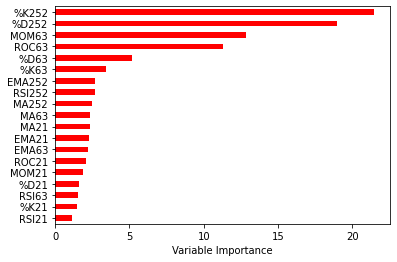

In [17]:
Importance = pd.DataFrame({'Importance':forest.feature_importances_*100}, index=X.columns)
print(Importance.sort_values('Importance', axis=0, ascending=True))
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None

In [18]:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm,neighbors
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [19]:
X_1=datasub.drop(['signal'],axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X_1, y, test_size=0.2, random_state=1)
print (X_train.shape, Y_train.shape)
print (X_test.shape, Y_test.shape)
from sklearn.preprocessing import RobustScaler
X_train_1=X_train.drop(['Close','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)
X_test_1=X_test.drop(['Close','High','Low','Open', 'Volume','short_mavg','long_mavg'], axis=1)

rs = RobustScaler()
rs.fit(X_train_1)
X_train_std = rs.transform(X_train_1)
X_test_std = rs.transform(X_test_1)

(3733, 27) (3733,)
(934, 27) (934,)


In [20]:
print(X_train)
print(X_test)

                                High         Low  ...        MA63       MA252
Ticker        Date                                ...                        
TATASTEEL.NS  2015-09-09  230.371719  221.368362  ...  251.793927  272.305974
JSWSTEEL.NS   2018-09-14  412.350006  402.200012  ...  340.264286  300.374603
TATASTEEL.NS  2019-01-09  497.299988  475.250000  ...  539.596825  590.571814
HINDALCO.NS   2016-09-12  150.600006  139.899994  ...  138.350794   96.116270
JINDALSTEL.NS 2017-08-16  139.800003  130.350006  ...  130.126984  100.551587
...                              ...         ...  ...         ...         ...
HINDALCO.NS   2017-10-17  277.899994  269.500000  ...  236.723809  196.128571
              2017-04-06  196.699997  191.350006  ...  185.633333  148.556746
JINDALSTEL.NS 2019-09-17  111.300003  101.599998  ...  123.010318  156.998214
TATASTEEL.NS  2017-03-17  484.704773  474.558105  ...  431.824855  366.334799
JINDALSTEL.NS 2016-12-27   67.050003   64.900002  ...   73.38650

In [21]:
# Spot Check Algorithms
data_Selected = []
data_Selected.append(('KNN', KNeighborsClassifier()))
data_Selected.append(('CART', DecisionTreeClassifier()))
data_Selected.append(('SVM', SVC()))
data_Selected.append(('RF', RandomForestClassifier()))
data_Selected.append(('NB', GaussianNB()))
# evaluate each model in turn
results = []
names = []
score=['f1','accuracy','precison','recall']
for name, model in data_Selected:
    kfold = model_selection.KFold(n_splits=10, random_state=1)
    cv_results =cross_val_score(model, X_train_std, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    output = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(output)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.958479 (0.007596)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


CART: 0.964899 (0.010904)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.935972 (0.008537)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


RF: 0.983390 (0.004765)
NB: 0.868732 (0.007291)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


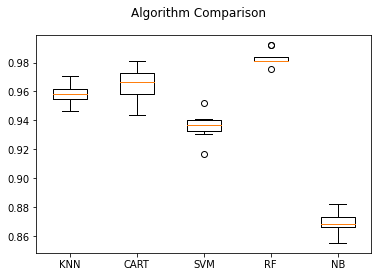

In [22]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [23]:
rf = RandomForestClassifier(n_estimators=500, min_samples_split=5,min_samples_leaf =2,max_features = 10,n_jobs=4,criterion='gini')
predy=rf.fit(X_train_std, Y_train)

In [24]:
predr= rf.predict(X_test_std)

In [25]:
print(accuracy_score(Y_test, predr))
print(confusion_matrix(Y_test, predr))
print(classification_report(Y_test, predr))

0.9860813704496788
[[399   2]
 [ 11 522]]
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       401
         1.0       1.00      0.98      0.99       533

    accuracy                           0.99       934
   macro avg       0.98      0.99      0.99       934
weighted avg       0.99      0.99      0.99       934



In [26]:
import itertools
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, accuracy_score, confusion_matrix,f1_score

def pltcm(ax, y_test, y_pred, classes, title, th=0.7, cmap=plt.cm.Reds):
    y_pred_labels = (y_pred>th).astype(int)
    
    cm = confusion_matrix(y_test, y_pred_labels)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)

    tickmarks = np.arange(len(classes))
    ax.set_xticks(tickmarks)
    ax.set_yticks(tickmarks)
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    ax.set_ylabel('Actual')
    ax.set_xlabel('Prediction')

def pltauc(ax, y_train, y_pred, y_test, y_tpred, th=0.7):

    y_predl = (y_pred>th).astype(int)
    y_tpredl  = (y_tpred>th).astype(int)

    fpr_tr, tpr_tr, _ = roc_curve(y_train,y_pred)
    roc_auc_tr = auc(fpr_tr, tpr_tr)
    acc_tr = accuracy_score(y_train, y_predl)

    fpr_ts, tpr_ts, _ = roc_curve(y_test,y_tpred)
    roc_auc_ts = auc(fpr_ts, tpr_ts)
    acc_ts = accuracy_score(y_test, y_tpredl)

    ax.plot(fpr_tr, tpr_tr)
    ax.plot(fpr_ts, tpr_ts)

    ax.plot([0, 1], [0, 1], 'k--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC curve')
    
    train_text = 'train acc = {:.3f}, auc = {:.2f}'.format(acc_tr, roc_auc_tr)
    test_text = 'test acc = {:.3f}, auc = {:.2f}'.format(acc_ts, roc_auc_ts)
    ax.legend([train_text, test_text])

def result(es,threshold,X_train,X_test,y_train,y_test):
    y_pred = es.predict(X_train)
    y_tpred = es.predict(X_test)

    fig,ax = plt.subplots(1,3)
    fig.set_size_inches(15,5)
    pltcm(ax[0],  y_train, y_pred, [0,1], 'Confusion matrix (TRAIN)', threshold)
    pltcm(ax[1],  y_test, y_tpred,   [0,1], 'Confusion matrix (TEST)', threshold)
    pltauc(ax[2], y_train, y_pred, y_test, y_tpred, threshold)
    plt.tight_layout()
    plt.show()
    
def btf1(es,X_test,y_test):
    thresholds = np.linspace(0.3,0.6,100)
    y_tpred = es.predict(X_test)
    score_set = []
    index_threshold = 0
    sum_score = 0
    for threshold in thresholds:
        y_tpred1  = (y_tpred > threshold).astype(int)
        score = f1_score(y_test, y_tpred1)
        score_set.append(score)
    for i in range(95):
        temp = sum(score_set[i:i+5])
        if temp > sum_score:
            sum_score = temp
            index_threshold = i+2 # the average threshold
    return thresholds[index_threshold],sum_score/5

def testf1(es,bestthreshold,X_test,y_test):
    y_tpred = es.predict(X_test)
    y_tpred1  = (y_tpred > bestthreshold).astype(int)
    score = f1_score(y_test, y_tpred1)
    return score

test f1: 0.9877010406811731 train f1: 0.9981006647673315


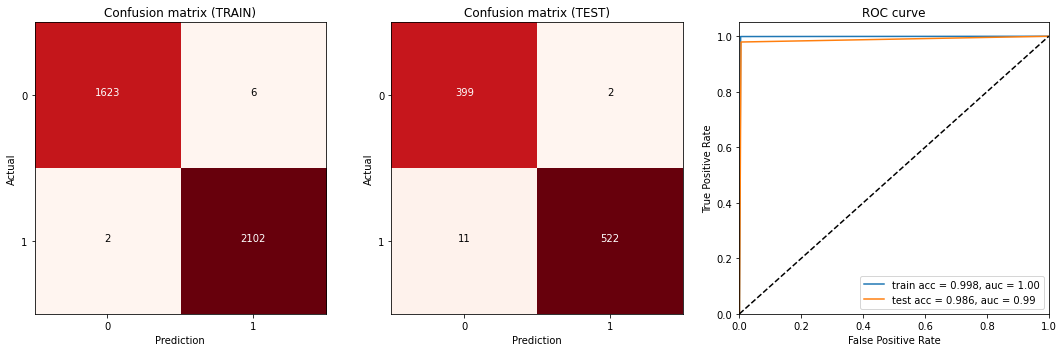

In [27]:
bestthreshold,bestf1 = btf1(rf,X_train_std, Y_train)
testf1 = testf1(rf,bestthreshold,X_test_std,Y_test)
print('test f1:',testf1,'train f1:',bestf1)
result(rf,bestthreshold,X_train_std,X_test_std, Y_train,Y_test)

,,signal_pred,signal_actual,Market Returns,Actual Returns,Strategy Returns
Ticker,Date,,,,,
HINDALCO.NS,2019-04-01,0.0,0.0,NaN,NaN,NaN
JSWSTEEL.NS,2015-04-23,0.0,0.0,-0.543516,-0.000000,-0.000000
HINDALCO.NS,2019-04-24,0.0,0.0,1.036426,0.000000,0.000000
JSWSTEEL.NS,2017-08-10,1.0,1.0,0.109865,0.000000,0.000000
HINDALCO.NS,2018-05-02,0.0,0.0,0.023794,0.023794,0.023794


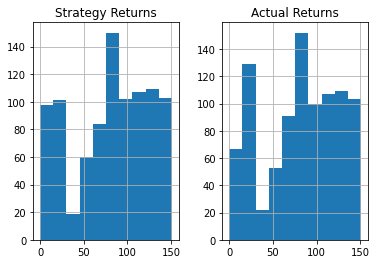

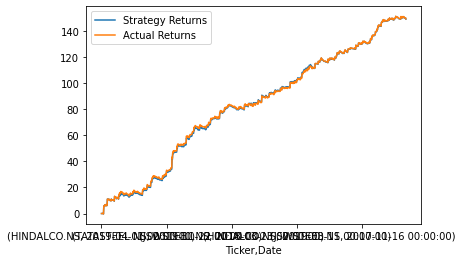

In [32]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_test.index)
backtestdata['signal_pred'] = predr
backtestdata['signal_actual'] = Y_test
backtestdata['Market Returns'] = X_test['Close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()
backtestdata.head()

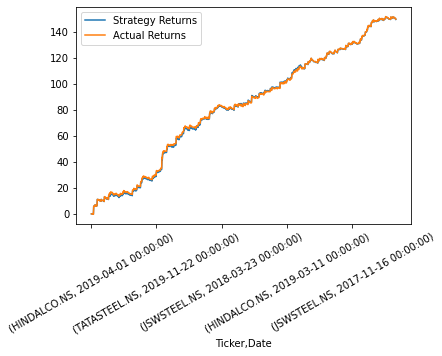

In [35]:
ax = backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()
plt.xticks(rotation=30)
plt.show()